In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [39]:
def single_lik(mu):
  y = tfd.Normal(mu,sigma_obs)
  return y


def prior():
  return tfd.Normal(mu0,sigma0)


def proposal(theta1):
  return tfd.Normal(theta1,2)


def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)


def K_h(u,h):
  return my_kernel(u/h)/h


def S1(y):
  quantiles=[]
  for i in range(9):
      quantiles.append(np.quantile(y,0.1+0.1*i))         #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles


def S2(y):
  return np.mean(y)

In [40]:
def lik(mu,n,y):
  med = 1/n*np.sum(y)
  yyy = []
  ssum = np.sum(yyy)
  for j in range(len(y)):
    yyy.append((y[j]-med)**2)
  res = math.e**(-1/(2*real_std)**2*(n*(mu-med)**2 + ssum))
  return res

In [41]:
##MAXIMAL COUPLING OF Y
def maximal_coupling2(theta_x,theta_y):
      proposed_x = single_lik(theta_x).sample()
      pX =  single_lik(theta_x).prob(proposed_x)
      w = tfd.Uniform(0,1).sample()*pX
      qX = single_lik(theta_y).prob(proposed_x)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = single_lik(theta_y).sample()
                qY =  single_lik(theta_y).prob(proposed_y) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = single_lik(theta_x).prob(proposed_y)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y  


      return [x_new, y_new]


In [42]:
##MAXIMAL COUPLING OF THETA
def maximal_coupling(x,y):
      current_x = x
      current_y = y  
      proposed_x = current_x + tfd.Normal(0,1).sample()
      pX = sstat.norm.pdf(proposed_x,current_x,1)
      w = tfd.Uniform(0,1).sample()*pX
      qX = sstat.norm.pdf(proposed_x,current_y,1)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = current_y + tfd.Normal(0,1).sample()
                qY =  sstat.norm.pdf(proposed_y,current_y,1) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = sstat.norm.pdf(proposed_y,current_x,1)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y  


      return [x_new, y_new]

In [43]:
### METROPOLIS HASTINGS nuovo

def metropolis_hastings(y_obs,S,h):    
    x_0 = prior().sample()
    y_0 = prior().sample()
    XX = []
    XXX = []
    YYY = [] 
    s_obs = S(y_obs)
    datax_current = single_lik(x_0).sample(1000)
    datay_current = single_lik(y_0).sample(1000) 
    sx_0 = S(datax_current)
    sy_0 = S(datay_current)
        
    while K_h(np.linalg.norm(np.array(sx_0)-np.array(s_obs)),h)<=0:
        x_0 = prior().sample()
        datax_0 = single_lik(x_0).sample(1000) 
        sx_0 = S(datax_0)

    while K_h(np.linalg.norm(np.array(sy_0)-np.array(s_obs)),h)<=0:
        y_0 = prior().sample()
        datay_0 = single_lik(y_0).sample(1000) 
        sy_0 = S(datay_0)
    
    x_old = x_0
    y_old = y_0
    XX.append([x_0,y_0])  
    sx_old = sx_0
    sy_old = sy_0
    

    for i in range(it):  
           print(i)   
           x_can, y_can = maximal_coupling(x_old,y_old)
           datax_current = []
           datay_current = []

           for j in range (100):
                  [newdata_x,newdata_y] = maximal_coupling2(x_can,y_can)
                  datax_current.append(newdata_x)
                  datay_current.append(newdata_y)
           

           sx_current = S(datax_current)
           sy_current = S(datay_current)          

           xprob = min([1.,(K_h(np.linalg.norm(np.array(sx_current) - np.array(s_obs)),h)*prior().prob(x_can))/(
               K_h(np.linalg.norm(np.array(sx_old)-np.array(s_obs)),h)*prior().prob(x_old))])
           yprob = min([1.,(K_h(np.linalg.norm(np.array(sy_current) - np.array(s_obs)),h)*prior().prob(y_can)/(
               K_h(np.linalg.norm(np.array(sy_old)-np.array(s_obs)),h)*prior().prob(y_old)))])
           
           u = tfd.Uniform(0,1).sample()

           if u < xprob :
               x_new = x_can
               sx_old = sx_current
           else: 
               x_new = x_old
           
           if u < yprob :
                y_new =y_can
                sy_old = sy_current
           else: 
                y_new= y_old 

           XX.append([x_new,y_new])
           XXX.append(x_new)
           YYY.append(y_new)
           x_old=x_new
           y_old=y_new
           
    return XXX,YYY,XX

In [46]:
##VARIABILI:
it=300
mu0 = 120
sigma0 = 4
n = 100
mu_obs = 123
sigma_obs = 3
y_obs = tfp.distributions.Normal(mu_obs,sigma_obs).sample(100)

In [ ]:
prova = metropolis_hastings(y_obs,S1,0.5)
plt.plot(prova[2])

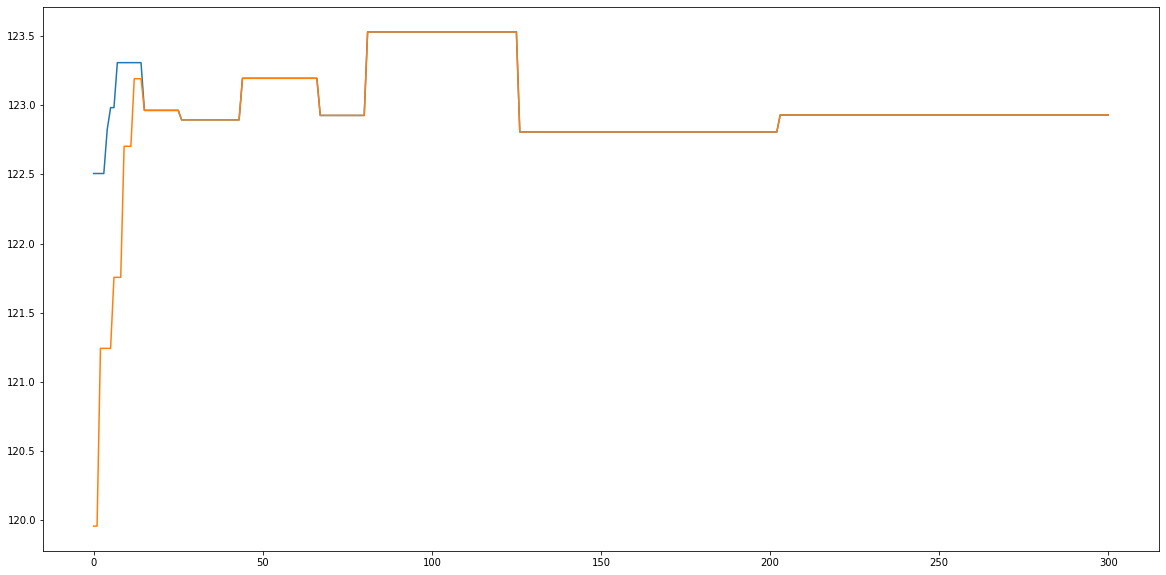

In [48]:
#from IPython.core.pylabtools import figsize
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.plot(prova[2])

In [ ]:
x = np.linspace(110,130, 100)
f,axs = plt.subplots(1,2)
axs[0].hist(prova[0][50:])
#axs[0].plot(x, 10000*real_posterior(mu0,1000,y_obs).prob(x))